In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import multilabel_confusion_matrix
from typing import Dict, List, Tuple
import numpy as np
import re
import string
import os
import json
import random
import pickle
import tqdm

# Fact checking system

## Data review

In [2]:
evidence_set = json.load(open('./data/evidence.json'))
len(evidence_set), type(evidence_set)

(1208827, dict)

In [3]:
list(evidence_set.keys())[:5]

['evidence-0', 'evidence-1', 'evidence-2', 'evidence-3', 'evidence-4']

In [4]:
evidence_set['evidence-0']

'John Bennet Lawes, English entrepreneur and agricultural scientist'

In [5]:
train_set = json.load(open('./data/train-claims.json'))
len(train_set), type(train_set)

(1228, dict)

In [6]:
list(train_set.keys())[:5]

['claim-1937', 'claim-126', 'claim-2510', 'claim-2021', 'claim-2449']

In [7]:
train_set['claim-1937']

{'claim_text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.',
 'claim_label': 'DISPUTED',
 'evidences': ['evidence-442946', 'evidence-1194317', 'evidence-12171']}

- claim_text: the text of the claim
- claim_label: {SUPPORTS, REFUTES, NOT ENOUGH INFO, DISPUTED}
- evidence: a list of evidence documents and the sentence index in those documents

## Task

1. Using Model to find the most relevant evidence to the claim.
2. Using Language Model to classify the claim_label.

### 1. Vectorization

In [8]:
# train a model that can shows relevant evidence for a given claim
# tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
# tokenizer = AutoTokenizer.from_pretrained("facebook/MobileLLM-125M", use_fast=False)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

/home/sec513/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
print(f"Max length of evidence: {max([len(evidence_set[e].split()) for e in evidence_set])}")
print(f"Index of Max length of evidence: {np.argmax([len(evidence_set[e].split()) for e in evidence_set])}")
print(f"Total number of evidence: {len(evidence_set)}")
print(f"Total number of claims: {len(train_set)}")

Max length of evidence: 479
Index of Max length of evidence: 358371
Total number of evidence: 1208827
Total number of claims: 1228


In [10]:
# make dataset
from torch.utils.data import Dataset, DataLoader
# Input: claim, evidence Output: 1 if evidence is relevant to claim, 0 otherwise

class EvidenceDataset(Dataset):
    def __init__(self, claim_set: Dict[str, str], evidence_set: Dict[str, str], tokenizer, max_length=768):
        self.claim_set = claim_set
        self.evidence_set = evidence_set
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.claim_keys = list(claim_set.keys())
        self.evidence_keys = list(evidence_set.keys())
        self.data = []
        self.positive_samples = 0
        self.negatives_samples = 0
        for claim_key in tqdm.tqdm(self.claim_keys):
            claim = claim_set[claim_key]
            for evidence_key in self.evidence_keys:
                evidence = evidence_set[evidence_key]
                # self.data.append((claim['claim_text'], evidence, 1 if evidence_key in claim['evidences'] else 0))
                if evidence_key in claim['evidences']:
                    self.data.append((claim['claim_text'], evidence, 1))
                    self.positive_samples += 1
                elif self.negatives_samples < self.positive_samples:
                    self.data.append((claim['claim_text'], evidence, 0))
                    self.negatives_samples += 1
        random.shuffle(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        claim, evidence, label = self.data[idx]
        inputs_claim = self.tokenizer(claim, max_length=512, padding="max_length", truncation=True, return_tensors="pt")
        inputs_evi = self.tokenizer(evidence, max_length=512, padding="max_length", truncation=True, return_tensors="pt")
        inputs = (inputs_claim['input_ids'], inputs_evi['input_ids'])
        return inputs, label
    
    def collate_fn(self, batch):
        inputs, labels = zip(*batch)
        input_ids_claim, input_ids_evi = zip(*inputs)
        input_ids_claim = torch.stack(input_ids_claim)
        input_ids_evi = torch.stack(input_ids_evi)
        labels = torch.tensor(labels)
        return (input_ids_claim, input_ids_evi), labels
    
    def get_labels(self):
        return [b[1] for b in self.data]
    
    def get_predictions(self, outputs):
        return outputs.logits.sigmoid().round().squeeze().tolist()
    
    def get_predictions_and_labels(self, outputs):
        return self.get_predictions(outputs), self.get_labels()
    
# get one and show shape

if os.path.exists('./data/dataset.pkl'):
    dataset = pickle.load(open('./data/dataset.pkl', 'rb'))
else:
    dataset = EvidenceDataset(train_set, evidence_set, tokenizer)
    # save dataset
    pickle.dump(dataset, open('./data/dataset.pkl', 'wb'))
inputs, label = dataset[0]

In [11]:
print(f"Positive samples: {dataset.positive_samples} Negative samples: {dataset.negatives_samples}")

Positive samples: 4122 Negative samples: 4122


In [12]:
inputs[0].shape, inputs[1].shape, label

(torch.Size([1, 512]), torch.Size([1, 512]), 0)

In [13]:
class RelevantModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.claim_encoder = torch.nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.evidence_encoder = torch.nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.linear = torch.nn.Linear(1024, 1)

    def forward(self, claim_input_ids, evidence_input_ids):
        claim_output = self.claim_encoder(claim_input_ids)
        evidence_output = self.evidence_encoder(evidence_input_ids)
        out_score = self.linear(torch.cat((claim_output, evidence_output), dim=1))
        return out_score
    
# test model

model = RelevantModel()
outputs = model(inputs[0].float(), inputs[1].float())
outputs.shape


torch.Size([1, 1])

In [14]:
# train model
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

EPOCHS = 10
BATCH_SIZE = 512
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = RelevantModel()
model.to(DEVICE)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=dataset.collate_fn)
losses = []
for epoch in range(EPOCHS):
    model.train()
    avg_loss = 0
    cnt = 0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        labels = labels.to(DEVICE)
        inputs_claim, inputs_evi = inputs
        inputs_claim = inputs_claim.to(DEVICE)
        inputs_evi = inputs_evi.to(DEVICE)
        inputs_claim = inputs_claim.squeeze().float()
        inputs_evi = inputs_evi.squeeze().float()
        outputs = model(inputs_claim, inputs_evi)
        avg_loss += loss_fn(outputs.squeeze(), labels.float()).item()
        loss = loss_fn(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        cnt += 1
        print(f"Epoch {epoch+1}/{EPOCHS} - batch {cnt}/{len(train_loader)} - loss: {avg_loss/cnt:.5f}", end="\r")
    losses.append(avg_loss/cnt)


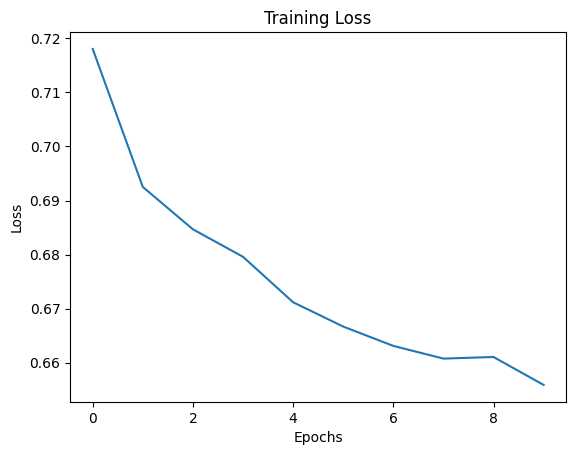

In [15]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [16]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
labels = []

for batch in train_loader:
    inputs, label = batch
    inputs_claim, inputs_evi = inputs
    inputs_claim = inputs_claim.to(DEVICE).squeeze().float()
    inputs_evi = inputs_evi.to(DEVICE).squeeze().float()
    outputs = model(inputs_claim, inputs_evi)
    preds = (outputs.sigmoid().round().squeeze().tolist())
    predictions += preds
    labels += label

cm = confusion_matrix(labels, predictions)
print(cm)
print(classification_report(labels, predictions))

[[2359 1763]
 [1344 2778]]
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      4122
           1       0.61      0.67      0.64      4122

    accuracy                           0.62      8244
   macro avg       0.62      0.62      0.62      8244
weighted avg       0.62      0.62      0.62      8244



### 2. Language Model

- Using Mamba to classify the claim_label.

In [17]:
# define model
import torch.nn as nn
import torch.nn.functional as F

# class SwiGLU(nn.Module):
#     def forward(self, x):
#         x, gate = x.chunk(2, dim=-1)
#         return F.silu(gate) * x

# class ClassifierModelSmall(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.core = nn.Sequential(
#             nn.Linear(768, 4096),
#             nn.Dropout(0.1),
#             SwiGLU(),
#             nn.Linear(2048, 768),
#             nn.LayerNorm(768)
#         )
#         self.linear = torch.nn.Linear(768, 4)
    
#     def forward(self, input_ids):
#         input_ids = input_ids.float()
#         outputs = self.core(input_ids)
#         return self.linear(outputs)
    
# test_tensor = torch.randint(0, 48051, (2, 768))
# model = ClassifierModelSmall()
# outputs = model(test_tensor)
# total_params = sum(p.numel() for p in model.parameters())/1e6
# outputs.shape, total_params

In [18]:
# define small bert model
class SmallBertModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = GPT2Model.from_pretrained('gpt2')
        self.linear = torch.nn.Linear(768, 4)
    
    def forward(self, input_ids):
        outputs = self.bert(input_ids)
        return self.linear(outputs.last_hidden_state[:, 0, :])
    
test_tensor = torch.randint(0, 48051, (2, 768))
model = SmallBertModel()
outputs = model(test_tensor)
total_params = sum(p.numel() for p in model.parameters())/1e6
outputs.shape, total_params

(torch.Size([2, 4]), 124.442884)

In [19]:
# make dataset (input: claim+evidence, output: label)
class ClassifierDataset(Dataset):
    def __init__(self, claim_set: Dict[str, str], evidence_set: Dict[str, str], tokenizer, max_length=768):
        self.claim_set = claim_set
        self.evidence_set = evidence_set
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.claim_keys = list(claim_set.keys())
        self.evidence_keys = list(evidence_set.keys())
        self.data = []
        self.max_token = 0
        # - claim_label: {SUPPORTS, REFUTES, NOT ENOUGH INFO, DISPUTED}
        self.labels_map = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
        self.labels_count = {"SUPPORTS": 0, "REFUTES": 0, "NOT_ENOUGH_INFO": 0, "DISPUTED": 0}
        for claim_key in tqdm.tqdm(self.claim_keys):
            claim = claim_set[claim_key]
            evidence_list = claim['evidences']
            temp_evidence = []
            for evidence_key in evidence_list:
                temp_evidence.append(evidence_set[evidence_key])
            temp_evidence = " ".join(temp_evidence)
            self.data.append((claim['claim_text'], temp_evidence, self.labels_map[claim['claim_label']]))
            self.labels_count[claim['claim_label']] += 1
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        claim, evidence, label = self.data[idx]
        inputs = self.tokenizer(claim, evidence, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        temp_max_token = torch.max(inputs['input_ids'])
        if temp_max_token > self.max_token:
            self.max_token = temp_max_token
        # label to one-hot
        label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=4)
        # convert to np array
        label = label.numpy()
        return inputs, label
    
    def collate_fn(self, batch):
        inputs, labels = zip(*batch)
        input_ids = [i['input_ids'] for i in inputs]
        input_ids = torch.stack(input_ids)
        labels = torch.tensor(labels)
        return input_ids, labels
    
    def get_labels(self):
        return [b[1] for b in self.data]
    
    def get_predictions(self, outputs):
        return outputs.logits.argmax(dim=1).squeeze().tolist()
    
    def get_predictions_and_labels(self, outputs):
        return self.get_predictions(outputs), self.get_labels()
    
# get one and show shape
dataset = ClassifierDataset(train_set, evidence_set, tokenizer)
inputs, label = dataset[0]
print(f"Supports: {dataset.labels_count['SUPPORTS']} Refutes: {dataset.labels_count['REFUTES']} Not enough info: {dataset.labels_count['NOT_ENOUGH_INFO']} Disputed: {dataset.labels_count['DISPUTED']}")
inputs['input_ids'].shape, label

100%|██████████| 1228/1228 [00:00<00:00, 103811.45it/s]

Supports: 519 Refutes: 199 Not enough info: 386 Disputed: 124


(torch.Size([1, 768]), array([1, 0, 0, 0]))

In [20]:
dataset.max_token , dataset.max_length

(tensor(50256), 768)

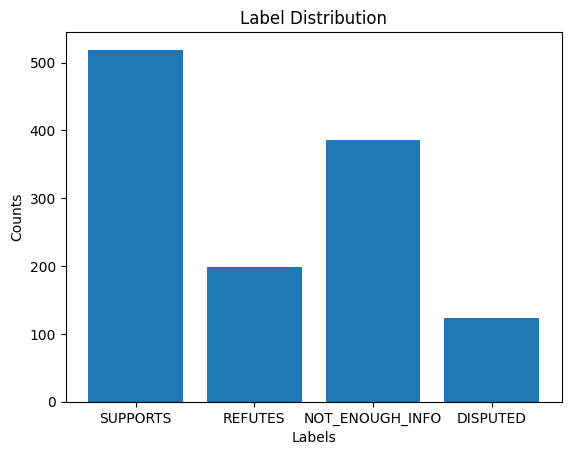

In [38]:
# print(f"Supports: {dataset.labels_count['SUPPORTS']} Refutes: {dataset.labels_count['REFUTES']} Not enough info: {dataset.labels_count['NOT_ENOUGH_INFO']} Disputed: {dataset.labels_count['DISPUTED']}")
# plot distribution
plt.bar(dataset.labels_count.keys(), dataset.labels_count.values())
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Label Distribution")
plt.show()

In [21]:
# clearup cuda memory
torch.cuda.empty_cache()
# train model
EPOCHS = 10
BATCH_SIZE = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = SmallBertModel()
model.to(DEVICE)
optimizer = AdamW(model.parameters(), lr=4e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=dataset.collate_fn)
losses = []
for epoch in range(EPOCHS):
    model.train()
    avg_loss = 0
    cnt = 0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        labels = labels.to(DEVICE)
        labels = labels.float()
        inputs = inputs.to(DEVICE)
        inputs = inputs.squeeze(1)  # Ensure the correct dimensions
        outputs = model(inputs)
        avg_loss += loss_fn(outputs, labels).item()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        cnt += 1
        print("                                                                                      ", end="\r")
        print(f"Epoch {epoch+1}/{EPOCHS} - batch {cnt}/{len(train_loader)} - loss: {avg_loss/cnt:.5f}", end="\r")
    losses.append(avg_loss/cnt)

/tmp/ipykernel_301916/2645981716.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  labels = torch.tensor(labels)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


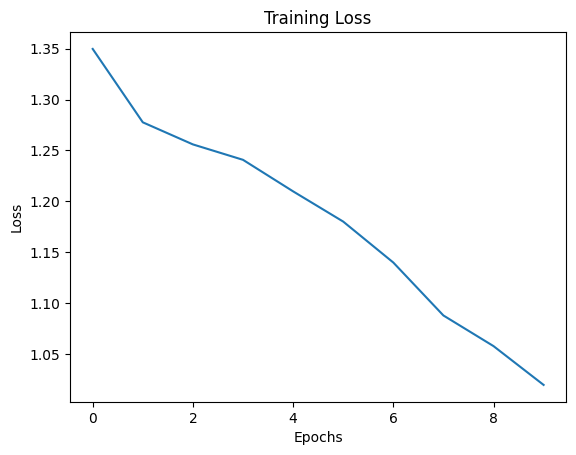

In [22]:
# plot loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [32]:
# confusion matrix
model.eval()
predictions = []
labels = []

for batch in train_loader:
    inputs, label = batch
    inputs = inputs.to(DEVICE)
    outputs = model(inputs)
    preds = (outputs.argmax(dim=1).squeeze().tolist())
    predictions += preds
    label = label.argmax(dim=1).squeeze().tolist()
    labels += label

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [37]:
cm = confusion_matrix(labels, np.argmax(predictions, axis=1))
print(cm)
print(classification_report(labels, np.argmax(predictions, axis=1)))

[[140  26 260  93]
 [ 51   0 101  47]
 [201  55  88  42]
 [ 34   7  78   5]]
              precision    recall  f1-score   support

           0       0.33      0.27      0.30       519
           1       0.00      0.00      0.00       199
           2       0.17      0.23      0.19       386
           3       0.03      0.04      0.03       124

    accuracy                           0.19      1228
   macro avg       0.13      0.13      0.13      1228
weighted avg       0.19      0.19      0.19      1228



In [39]:
# dev
dev_set = json.load(open('./data/dev-claims-baseline.json'))
len(dev_set), type(dev_set)

(154, dict)

In [44]:
# make dataset
dev_dataset = ClassifierDataset(dev_set, evidence_set, tokenizer)
inputs, label = dev_dataset[0]
inputs['input_ids'].shape, label

100%|██████████| 154/154 [00:00<00:00, 270827.18it/s]


(torch.Size([1, 768]), array([0, 1, 0, 0]))

In [45]:
# inference
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dev_dataset.collate_fn)
model.eval()
predictions = []

for batch in dev_loader:
    inputs, label = batch
    inputs = inputs.to(DEVICE)
    outputs = model(inputs)
    preds = (outputs.argmax(dim=1).squeeze().tolist())
    predictions += preds

In [47]:
predictions = np.argmax(predictions, axis=1)

In [50]:
label_map = {0: "SUPPORTS", 1: "REFUTES", 2: "NOT_ENOUGH_INFO", 3: "DISPUTED"}

In [51]:
# write to file
with open('./data/dev-claims-baseline_my.json', 'w') as f:
    for i, claim_key in enumerate(dev_set):
        dev_set[claim_key]['claim_label'] = label_map[predictions[i]]
    json.dump(dev_set, f)